In [38]:
%pip install torchdiffeq

Note: you may need to restart the kernel to use updated packages.


In [39]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt 

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from functools import partial
from torch.autograd.functional import jacobian, hessian

from torchdiffeq import odeint as tor_odeint
from torchdiffeq import odeint_adjoint as tor_odeintadj
torch.version.__version__

'2.1.2'

Lagrangian for spring pendulum, in 2D, with $r$ spring length, $\theta$ angle from vertical: 

$\mathcal{L} = T - V = \frac{1}{2}\dot{r}^2 + \frac{1}{2} r^2\dot{\theta}^2 - gr(1-\cos(\theta)) - k(r -r_0)^2$

By applying Euler Lagrange equations get:

$\ddot r = r\dot{\theta}^2 + g(1-\cos(\theta)) - 2k(r-r_0)$

and 

$\ddot \theta = -\frac{1}{r}(g\sin(\theta) + 2\dot{r}\dot{\theta})$

can use these and `odeint` to solve analytically.



In [40]:
def lagrangian(x, g=10, k=10):
    q, qt = torch.split(x, 2)
    T = 0.5*(qt[0]**2 + (q[0]*qt[1])**2)
    V = g*q[0]*(1-torch.cos(q[1])) + k*(q[0] - 1)**2
    return T - V 

# If x is a tensor, E will return a tensor. If not, then a np array.

def E(x, g=10, k=10):
    try:
        q, qt = torch.split(x, 2)
        cos = torch.cos
    except: 
        q, qt = np.split(x, 2)
        cos = np.cos
    T = 0.5*(qt[0]**2 + (q[0]*qt[1])**2)
    V = g*q[0]*(1-cos(q[1])) + k*(q[0] - 1)**2
    return T + V 


def spring_pend_acc(q, qt, g=10, k=10):
    '''
    q is [r, theta]
    qdot is [rdot, thetadot]

    returns q double dot.
    '''
    qdtt = np.zeros_like(q)

    qdtt[:, 0] = q[:, 0]*qt[:, 1]**2 - g*(1-np.cos(q[:, 1])) - 2*k*(q[:, 0]-1) 
    qdtt[:, 1] = (-g*np.sin(q[:, 1]) -2*qt[:, 0]*qt[:, 1])/q[:, 0]

    return qdtt  


In [41]:
def get_qdotdot(total_state, analytical_solution):
    '''
    total_state is a tensor of generalised coords and velocities,
    returns q double dot.
    '''
    dims = total_state.shape[1]//2
    if dims%2 != 0:
        raise ValueError("The input total_state must have an even number of columns.")
    return analytical_solution(total_state[:, :dims], total_state[:, dims:])


# Returns q_dot and q_dotdot 

#Want to make these functions as general as possible. so that they can be used for any system.

def analytically_differentiated_state(x, t, analytical_solution):
    d = np.zeros_like(x)
    
    #Remove 2's, make it general
    n_cols = x.shape[1]
    if n_cols % 2 != 0:
        raise ValueError("The input x must have an even number of columns.")
    d[:, :n_cols//2] = x[:, n_cols//2:]
    d[:, n_cols//2:] = get_qdotdot(x, analytical_solution)
    return d


# This takes only 4 numbers: the starting position and velocity. 
# f_analytic function returns q_dot and q_dotdot for 1 dimensional inputs.

# Returns:
# An array containing the value of y for each desired time in t, with the initial value y0 in the first row.


def ode_solve_analytic(q0, qt0, t, analytical_solution):

    x0 = np.append(q0, qt0)

    def f_analytic(x, t):
        d = np.zeros_like(x)
        n_cols = x.shape[0]
        d[:n_cols//2] = x[n_cols//2:]
        d[n_cols//2:] = np.squeeze(get_qdotdot(np.expand_dims(x, axis=0), analytical_solution))
        # print(x, d)
        return d
    
    return odeint(f_analytic, x0, t, rtol=1e-10, atol=1e-10)
    



In [42]:
def polar_to_cartesian(ql):
    '''
    Polar coords to xy
    '''
    try: 
        xy = np.zeros_like(ql)
        sin = np.sin
        cos = np.cos
        print("np")
    except: 
        xy = torch.zeros_like(ql)
        sin = torch.sin
        cos = torch.cos

    xy[:, 0] = ql[:, 0]*sin(ql[:, 1])
    xy[:, 1] = -ql[:, 0]*cos(ql[:, 1])
    return xy  

In [43]:
t = np.arange(0, 5, 0.005)

# We initialized two posiiton vectors (and their corrosponding velocities to zero) 
# to see how a small variation effects the trajectory.

q0 = np.array([1.1, 0.5])
q0p = np.array([1.1 + 1e-5, 0.5])
qt0 = np.array([0.0, 0.0])

# %timeit path = ode_solve_analytic(q0, qt0, t)
path = ode_solve_analytic(q0, qt0, t, spring_pend_acc)
ppath = ode_solve_analytic(q0p, qt0, t, spring_pend_acc)
xy = polar_to_cartesian(path)
pxy = polar_to_cartesian(ppath)

np
np


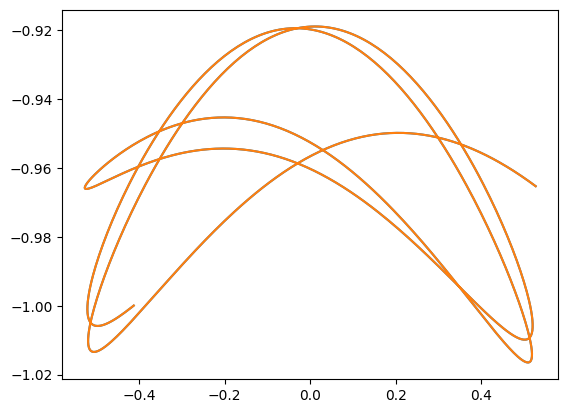

In [44]:
plt.plot(xy[:, 0], xy[:, 1])
plt.plot(pxy[:, 0], pxy[:, 1])

We can also solve using pytorch to autodiff the lagrangian, an use the following version of the EL equations (after Cranmer et al.), with $q=(r, \theta)$:

$\ddot q = (\nabla_{\dot q}\nabla_{\dot q}^{\top}\mathcal{L})^{-1}[\nabla_q \mathcal{L} - (\nabla_{q}\nabla_{\dot q}^{\top}\mathcal{L})\dot q]$





In [45]:
# Gets the q_dot, q_dotdot by differentiating a function "lagrangian" wrt E-L equations.

def get_xt(lagrangian, t, x):
    n = x.shape[0]//2
    xv = torch.autograd.Variable(x, requires_grad=True)
    tq, tqt = torch.split(xv, 2, dim=0)

    A = torch.inverse(hessian(lagrangian, xv, create_graph=True)[n:, n:])
    B = jacobian(lagrangian, xv, create_graph=True)[:n]
    C = hessian(lagrangian, xv, create_graph=True)[n:, :n]

    tqtt = A @ (B - C @ tqt)

    xt = torch.cat([tqt, torch.squeeze(tqtt)])

    return xt


# This takes the starting coordinates and f fills the first argument of get_xt with "lagrangian",
# so that this can directly go into tor_odeint function, which is similar to the previous one.
def torch_solve_ode(x0, t, lagrangian):
    f = partial(get_xt, lagrangian)
    return tor_odeint(f, x0, t)

In [46]:
# Solving the system using the analytically provided Lagrangian!

tx0 = torch.cat([torch.tensor(q0), torch.tensor(qt0)])
tt = torch.tensor(t)
tpath = torch_solve_ode(tx0, tt, lagrangian)

# %timeit tpath = torch_solve_ode(tx0, tt, lagrangian)
txy = polar_to_cartesian(tpath)

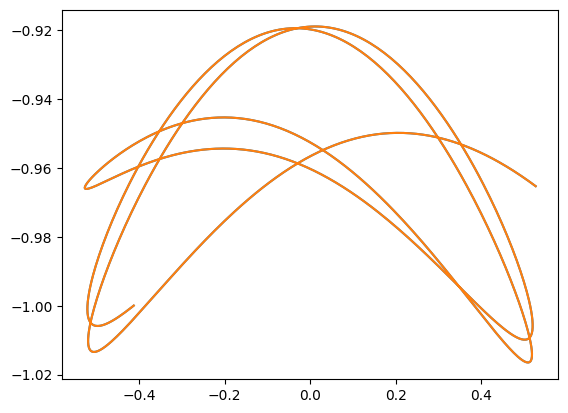

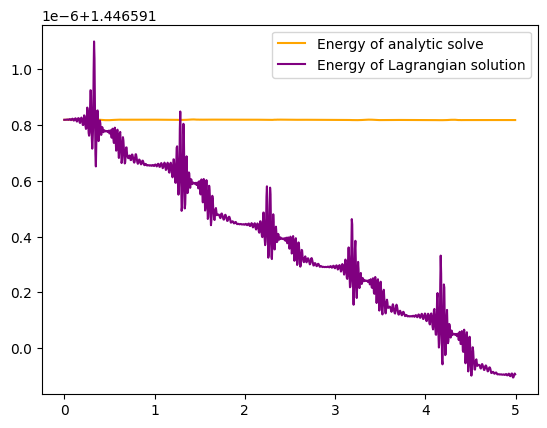

In [47]:
plt.plot(xy[:, 0], xy[:, 1])
plt.plot(txy.detach()[:, 0], txy.detach()[:, 1])
En = [E(x) for x in path]
Ent = [E(x) for x in tpath.detach()]
plt.show()
plt.plot(t, En, color='orange', label='Energy of analytic solve')

plt.plot(t, Ent, color='purple', label= 'Energy of Lagrangian solution')

plt.legend()

plt.show()

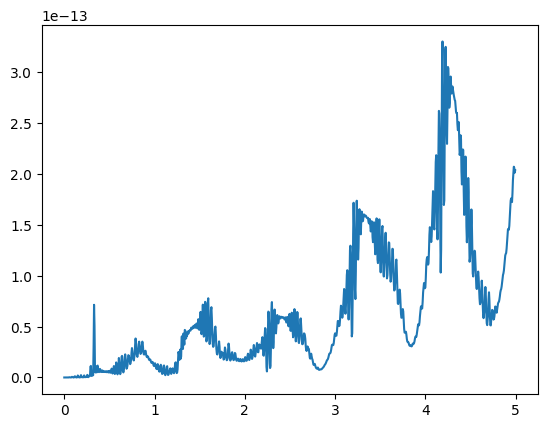

In [48]:
# Mean square difference between analytical straight solution and analytical Lagrangian solution.

plt.plot(t, np.sum((tpath.detach().numpy() - path)**2, axis=1))

In [49]:
def rk4_step(f, x, t, h):
  # one step of runge-kutta integration
  k1 = h * f(x, t)
  k2 = h * f(x + k1/2, t + h/2)
  k3 = h * f(x + k2/2, t + h/2)
  k4 = h * f(x + k3, t + h)
  return x + 1/6 * (k1 + 2 * k2 + 2 * k3 + k4)

In [50]:
def random_initialize(start=0, end=10, dim=2, distribution='uniform'):
    if distribution == 'uniform':
        positions = np.random.uniform(start, end, size=(dim,))
        return positions
    if distribution == 'gaussian':
        mean = (start + end) / 2  # Mean of the Gaussian distribution
        std_dev = (end - start) / (2 * np.sqrt(3))  # Standard deviation of the Gaussian distribution
        positions = np.random.normal(mean, std_dev, size=(dim,))
        # Clip values to ensure they fall within the specified range
        positions = np.clip(positions, start, end)
        return positions
    else:
        raise ValueError("Invalid distribution type. Please choose 'uniform' or 'gaussian'.")

In [51]:
#starting_positions = random_initialize(0,10)
starting_positions = np.array([1.1, 0.5])
starting_velocities = np.array([0.0, 0.0])
#starting_velocities = random_initialize(0, 2, 2, 'gaussian')


In [52]:
t_start = 0 
t_end = 20
total_data_points = 3000

In [55]:
t_total = torch.tensor(np.linspace(t_start, t_end, total_data_points)).float()

train_indices = torch.randperm(total_data_points)
t_train = t_total[train_indices]

tstep = t_total[1].item() 

In [57]:
#q_train is still only considering only the same system with the same phase space!

q_qdot_total = torch.tensor(ode_solve_analytic(starting_positions, starting_velocities, t_total, spring_pend_acc)).float()
print("State",q_qdot_total)

q_qdot_train = q_qdot_total[train_indices]
q_qdot_test = q_qdot_total



qdot_qdotdot_total = torch.tensor(analytically_differentiated_state(q_qdot_total, t_total, spring_pend_acc)).float()

print("Differentiated state")
print(qdot_qdotdot_total)

qdot_qdotdot_train = qdot_qdotdot_total[train_indices]


State tensor([[ 1.1000,  0.5000,  0.0000,  0.0000],
        [ 1.0999,  0.4999, -0.0215, -0.0291],
        [ 1.0997,  0.4996, -0.0430, -0.0581],
        ...,
        [ 1.0880, -0.4277,  0.3965, -0.7244],
        [ 1.0906, -0.4324,  0.3822, -0.6955],
        [ 1.0931, -0.4369,  0.3671, -0.6666]])
Differentiated state
tensor([[ 0.0000,  0.0000, -3.2242, -4.3584],
        [-0.0215, -0.0291, -3.2213, -4.3591],
        [-0.0430, -0.0581, -3.2129, -4.3610],
        ...,
        [ 0.3965, -0.7244, -2.0901,  4.3400],
        [ 0.3822, -0.6955, -2.2052,  4.3298],
        [ 0.3671, -0.6666, -2.3161,  4.3191]])


In [62]:
class LNN(nn.Module):
    def __init__(self):
        super(LNN, self).__init__()
        self.fc1 = nn.Linear(4, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, 1)
    
    def lagrangian(self, x): 
        x = F.softplus(self.fc1(x))
        x = F.softplus(self.fc2(x))
        x = self.fc3(x)
        return x 

    def forward(self, x):
        n = x.shape[1]//2
        xv = torch.autograd.Variable(x, requires_grad=True)
        xv_tup = tuple([xi for xi in x]) 

        #xv_tup is tuple of "states" in various time frames.
        tqt = xv[:, n:]

        jacpar = partial(jacobian,  self.lagrangian, create_graph=True)
        hesspar = partial(hessian,  self.lagrangian, create_graph=True)

        A = tuple(map(hesspar, xv_tup))
        B = tuple(map(jacpar, xv_tup))
        
        #Why tuple?

        #print("A:", A)
        
        multi = lambda Ai, Bi, tqti, n:  torch.pinverse(Ai[n:, n:]) @ (Bi[:n, 0] - Ai[n:, :n] @ tqti) 
        multi_par = partial(multi, n=n)

        tqtt_tup = tuple(map(multi_par, A, B, tqt))
        tqtt = torch.cat([tqtti[None] for tqtti in tqtt_tup])

        xt = torch.cat([tqt, tqtt], axis=1)
        xt.retain_grad()
        return xt

    def t_forward(self, t, x):
        return self.forward(x)

def loss(pred, targ):
    return torch.mean((pred - targ)**2)

def nn_solve_ode(model, x0, t):

    x0 = x0.detach().numpy()
    def f(x, t):
        x_tor = torch.tensor(np.expand_dims(x, 0), requires_grad=True).float()
        return np.squeeze(model(x_tor).detach().numpy(), axis=0)
    return odeint(f, x0, t, full_output=1)  

In [63]:
eps = 100
N = 1500 
batch_size = 100 

model = LNN()

optimizer = optim.Adam(model.parameters(), lr=1e-3)
loss_list = []
for e in range(eps):
    running_loss = 0.
    for i in range(1, N // batch_size):
        optimizer.zero_grad()
        xi = q_qdot_train[(i-1)*batch_size:i*batch_size]
        xdot_xdotdot_pred = model(xi)

        loss_val = loss(xdot_xdotdot_pred, qdot_qdotdot_train[i])
        loss_val.backward()

        optimizer.step()

        running_loss += loss_val.item()

    print('Epoch %d loss: %.10f' % (e + 1, running_loss/N))
    loss_list.append(running_loss/N)
        
        

Epoch 1 loss: 0.0911159143
Epoch 2 loss: 0.0651620258
Epoch 3 loss: 0.0626910098
Epoch 4 loss: 0.0624042409
Epoch 5 loss: 0.0621284790
Epoch 6 loss: 0.0618624878
Epoch 7 loss: 0.0616018521
Epoch 8 loss: 0.0612852443
Epoch 9 loss: 0.0608950036
Epoch 10 loss: 0.0604323896
Epoch 11 loss: 0.0599045410
Epoch 12 loss: 0.0593378490
Epoch 13 loss: 0.0588110148
Epoch 14 loss: 0.0584713802
Epoch 15 loss: 0.0584202086
Epoch 16 loss: 0.0585273682
Epoch 17 loss: 0.0585852620
Epoch 18 loss: 0.0585784388
Epoch 19 loss: 0.0585439952
Epoch 20 loss: 0.0585120409
Epoch 21 loss: 0.0584890316
Epoch 22 loss: 0.0584700788
Epoch 23 loss: 0.0584524835
Epoch 24 loss: 0.0584349985
Epoch 25 loss: 0.0584173352
Epoch 26 loss: 0.0583997080
Epoch 27 loss: 0.0583822443
Epoch 28 loss: 0.0583649623
Epoch 29 loss: 0.0583478560
Epoch 30 loss: 0.0583309027
Epoch 31 loss: 0.0583140761
Epoch 32 loss: 0.0582973668
Epoch 33 loss: 0.0582807639
Epoch 34 loss: 0.0582642632
Epoch 35 loss: 0.0582478555
Epoch 36 loss: 0.0582315397
E

In [ ]:
torch.save(model, '/kaggle/working/model_april29.pt')

In [ ]:
#model = torch.load('/kaggle/input/first_model_lnn/pytorch/first/1/model.pt')
#model.eval()

In [71]:
print(t_total.shape)

torch.Size([3000])


In [72]:

#t_test should be either decreasing or increasing!!!

nn_test = nn_solve_ode(model, q_qdot_test[0], t_total)


 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2803139562031D+01   r2 =  0.1992682281776D-15
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2803139562031D+01   r2 =  0.1992682281776D-15
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2803139562031D+01   r2 =  0.1947393073546D-15
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2803139562031D+01   r2 =  0.9736965367728D-16
 lsoda--  warning..internal t (=r1) 

/tmp/ipykernel_34/463444208.py:54: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  return odeint(f, x0, t, full_output=1)


(array([[ 1.10000002e+000,  5.00000000e-001,  0.00000000e+000,
         0.00000000e+000],
       [ 1.09996531e+000,  5.00017015e-001, -1.04002308e-002,
         5.09834264e-003],
       [ 1.09986124e+000,  5.00068064e-001, -2.08095783e-002,
         1.02115135e-002],
       ...,
       [ 6.55591076e-310,  6.55617098e-310,  6.55591076e-310,
         6.55617098e-310],
       [ 6.55591076e-310,  6.55617098e-310,  6.55591076e-310,
         6.55617098e-310],
       [ 6.55591076e-310,  6.55617098e-310,  6.55591076e-310,
         6.55617098e-310]]), {'hu': array([0.00620351, 0.00620351, 0.00620351, ..., 1.08532858, 1.08801842,
       1.09061587]), 'tcur': array([1.06319714e-002, 1.68354848e-002, 2.30389982e-002, ...,
       6.55591096e-310, 6.55591096e-310, 6.55591096e-310]), 'tolsf': array([1.33406306e+185, 1.33406306e+185, 1.33406306e+185, ...,
       6.55591098e-310, 6.55591098e-310, 6.55591098e-310]), 'tsw': array([0., 0., 0., ..., 0., 0., 0.]), 'nst': array([   8,    9,   10, ..., 1696, 

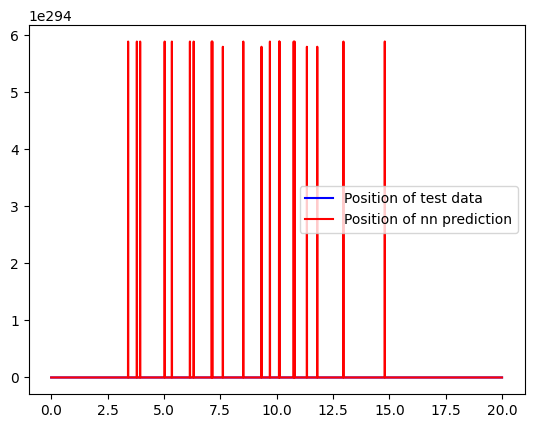

In [76]:
plt.plot(t_total, q_qdot_test[:, 0], color='blue', label='Position of test data')
print(nn_test)
plt.plot(t_total, nn_test[0][:, 0], color='red', label='Position of nn prediction')
plt.legend()
plt.show()
#plt.plot(np.arange(len(loss_list)), loss_list)
#plt.yscale('log')


In [78]:
for i in range(100):
    print((nn_test[0][i], q_qdot_test[i]))

(array([1.10000002, 0.5       , 0.        , 0.        ]), tensor([1.1000, 0.5000, 0.0000, 0.0000]))
(array([ 1.09996531,  0.50001702, -0.01040023,  0.00509834]), tensor([ 1.0999,  0.4999, -0.0215, -0.0291]))
(array([ 1.09986124,  0.50006806, -0.02080958,  0.01021151]), tensor([ 1.0997,  0.4996, -0.0430, -0.0581]))
(array([ 1.09968772,  0.50015326, -0.03122822,  0.0153396 ]), tensor([ 1.0994,  0.4991, -0.0643, -0.0872]))
(array([ 1.0994447 ,  0.5002727 , -0.04165635,  0.0204827 ]), tensor([ 1.0989,  0.4984, -0.0856, -0.1164]))
(array([ 1.0991321 ,  0.50042649, -0.05209417,  0.02564088]), tensor([ 1.0982,  0.4976, -0.1067, -0.1455]))
(array([ 1.09874986,  0.50061472, -0.06254187,  0.03081425]), tensor([ 1.0974,  0.4965, -0.1277, -0.1747]))
(array([ 1.09829791,  0.50083751, -0.07299965,  0.03600288]), tensor([ 1.0965,  0.4952, -0.1484, -0.2039]))
(array([ 1.09777618,  0.50109496, -0.08346769,  0.04120688]), tensor([ 1.0955,  0.4938, -0.1688, -0.2332]))
(array([ 1.09718461,  0.50138716, -0

/tmp/ipykernel_34/307661751.py:16: RuntimeWarning: overflow encountered in scalar multiply
  T = 0.5*(qt[0]**2 + (q[0]*qt[1])**2)
/tmp/ipykernel_34/307661751.py:17: RuntimeWarning: overflow encountered in scalar power
  V = g*q[0]*(1-cos(q[1])) + k*(q[0] - 1)**2
/tmp/ipykernel_34/307661751.py:16: RuntimeWarning: overflow encountered in scalar power
  T = 0.5*(qt[0]**2 + (q[0]*qt[1])**2)


ValueError: Axis limits cannot be NaN or Inf

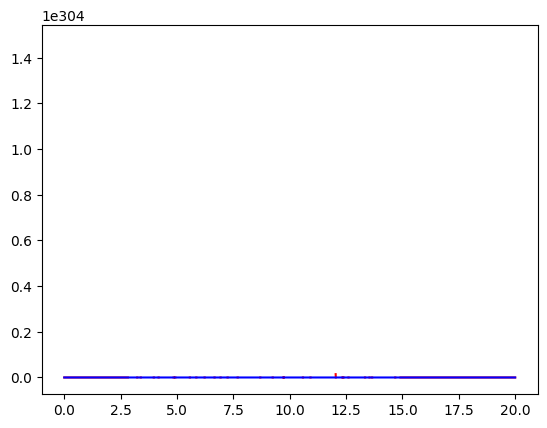

In [82]:
E_test = [E(x) for x in q_qdot_test]
E_lnn = [E(x) for x in nn_test[0]]

plt.plot(t_total, E_lnn, color='red', label='E_lnn')
plt.plot(t_total, E_test, color='blue', label='E_train')


plt.ylim(min(min(E_test), min(E_lnn))-0.02, max(max(E_test), max(E_lnn)))
plt.legend()

plt.show()

In [ ]:
from mpl_toolkits.mplot3d import Axes3D

def Lagr(x, g=10, k=10):
    q, qt = torch.split(x, 2)
    T = 0.5*(qt[0]**2 + (q[0]*qt[1])**2)
    V = g*q[0]*(1-torch.cos(q[1])) + k*(q[0] - 1)**2
    return T - V 


def Lagr(x,y):
    q, qt = x, y
    T = 0.5*(qt[0]**2 + (q[0]*qt[1])**2)
    V = g*q[0]*(1-torch.cos(q[1])) + k*(q[0] - 1)**2
    return T - V 

# Generate x and y values
x = q_qdot_total[:,0]
print(x)
y = q_qdot_total[:,1]
print(torch.stack((x,y),1))
X, Y = torch.meshgrid(x,y)
Z = Lagr(X, Y)

# Create a 3D plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot the surface
surf = ax.plot_surface(X, Y, Z, cmap='viridis')

# Add labels and title
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('f(x, y)')
ax.set_title('Surface Plot of f(x, y)')

# Add color bar
fig.colorbar(surf)

# Show the plot
plt.show()
